# 0.0 IMPORTS

In [1]:
import numpy as np
import pandas as pd
import inflection
import math
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import HTML
from IPython.display import Image

%matplotlib inline

## 0.1 Helpers Functions

## 0.2 Loading Data

In [2]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory= False)
df_store_raw = pd.read_csv('data/store.csv', low_memory= False)

# merge

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 DATA DESCRIPTION

In [3]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [4]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# Rename
df1.columns = cols_new

## 1.2 Data Dimentions

In [5]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of cols: 18


## 1.3 Data Types

In [6]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [7]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [8]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else (x))

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply ( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis =1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply ( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis =1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply ( lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis =1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply ( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis =1)



In [9]:
# promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace = True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 
                                                             else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

## 1.6 Change Types

In [10]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [11]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

In [12]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'int32', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [13]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - Std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.155231,0.0,0.362124,1.904152,1.625796


<AxesSubplot:xlabel='competition_distance'>

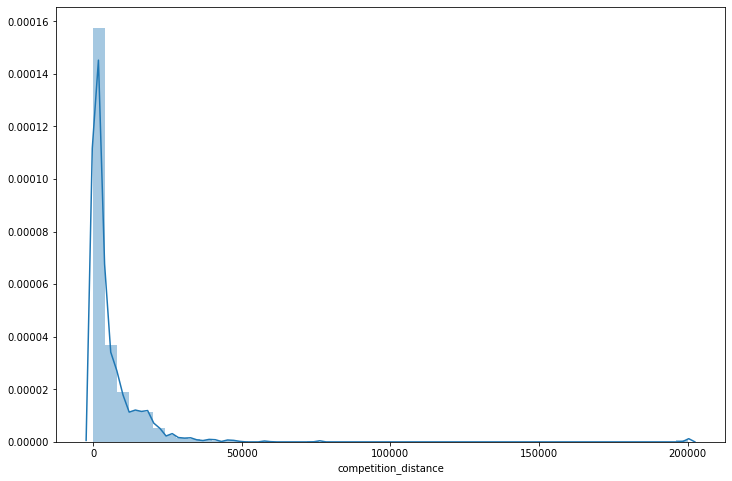

In [14]:
plt.figure(figsize = (12, 8))
sns.distplot(df1['competition_distance'])

### 1.7.2 Categorical Attributes

In [15]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

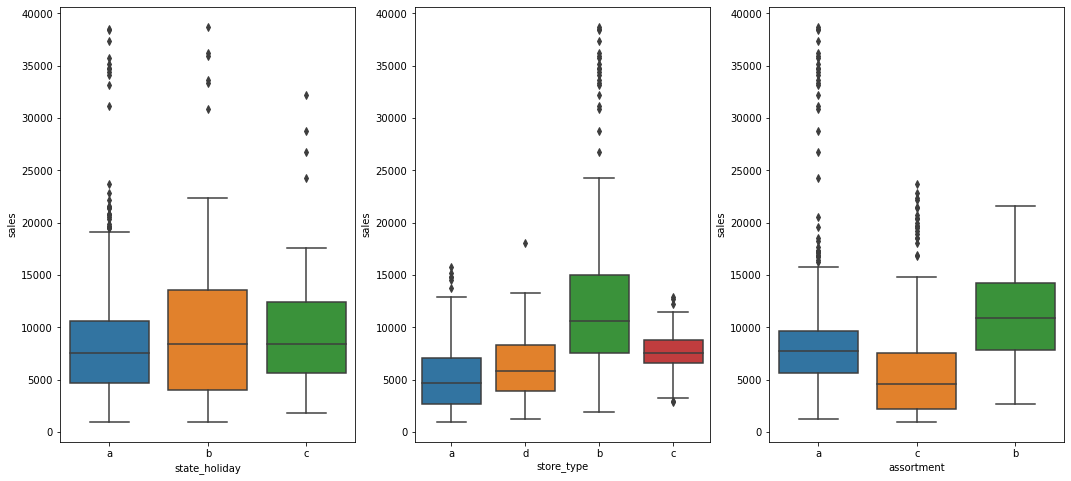

In [16]:
plt.figure(figsize = (18, 8))
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1, )

plt.subplot(1,3,2)
sns.boxplot(x = 'store_type', y = 'sales', data = aux1, )

plt.subplot(1,3,3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux1, )

# 2.0 FEATURE ENGENEERING

In [17]:
df2 = df1.copy()

## 2.1 Mind Map Hypotheses

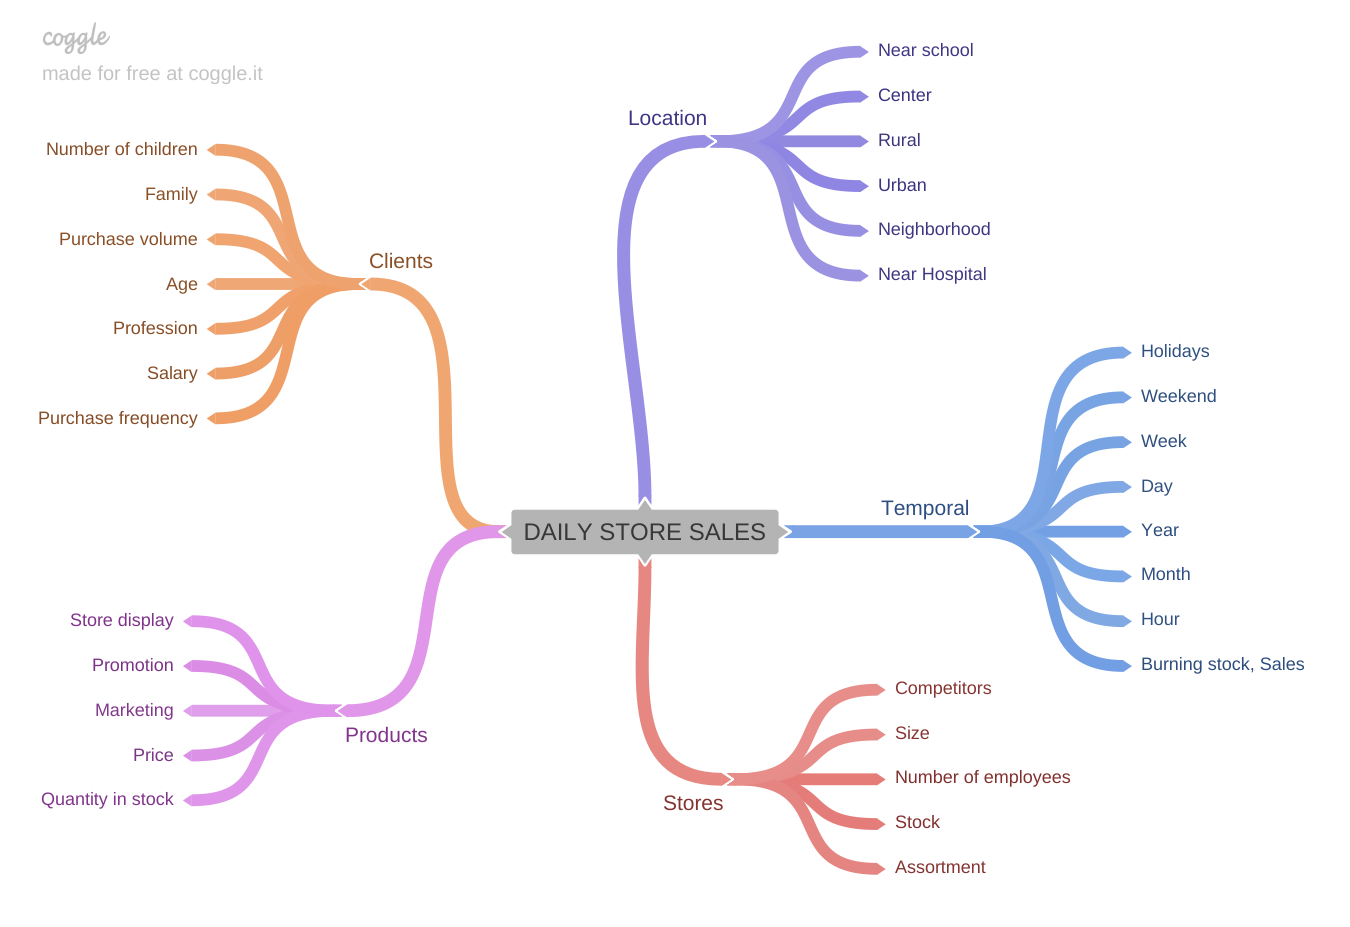

In [18]:
Image ('img/mindmaps.png')

## 2.2 Hypotheses criation

### 2.2.1 Hypotheses Stores

**1.** Stores with more employees should have more sales.

**2.** Stores with more products in stock should have more sales.

**3.** Stores with more assortment should  have more sales.

**4.** Stores with bigger size should  have more sales.

**5.** Stores with closer competitors should sell less.

**6.** Stores with longer competitors should sell more.

**7.** Stores with home delivery should sell more.

### 2.2.2 Hypotheses Clients

**1.** Stores with customers with the largest number of children should have more sales.

**2.** Stores with customers with family should have more sales.

**3.** Stores with older customers should sell more.

**4.** Stores with customers with high-paying jobs should sell more.

**5.** Stores with high purchase frequency per client should sell more.

**6.** Stores ith high purchase volume per client should sell more.

**7.** Stores with more clients should sell more.

### 2.2.3 Hypotheses Products

**1.** Stores with more investment in marketing should have more sales.

**2.** Stores that show more products in showcases should sell more.

**3.** Stores with lower prices should have more sales.

**4.** Higher discount stores should sell more.

**5.** Stores that carry out extended promotions should sell more.

**6.** Stores with large stock should have more sales.

**7.** Stores with more days of promotions should sell more.

**8.** Stores with more consecutive promotions should sell more.

### 2.2.4 Hypotheses Temporal

**1.** Stores open during the Christmas holiday should sell more.

**2.** Older stores should sell more.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell more after the 10th of each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

**7.** Stores that works 24 hours should sell more.

### 2.2.5 Hypotheses Location

**1.** Stores in urban areas should sell more.

**2.** Stores in city centers should sell more.

**3.** Stores in rural areas should sell less.

**4.** Residential neighborhood stores should sell more.

**5.** Stores near schools should sell more.

**6.** Stores near hospitals should sell more.

## 2.3 Hypotheses final list

**1.** Stores with bigger size should  have more sales.

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer competitors should sell more.

**4.** Stores that carry out extended promotions should sell more.

**5.** Stores with more days of promotions should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores with more clients should sell more.

**8.** Stores open during the Christmas holiday should sell more.

**9.** Older stores should sell more.

**10.** Stores should sell more in the second half of the year.

**11.** Stores should sell more after the 10th of each month.

**12.** Stores should sell less on weekends.

**13.** Stores should sell less during school holidays.

## 2.4 Feature Engineering

In [19]:
# Year
df2['year'] = df2['date'].dt.year

# Month
df2['month'] = df2['date'].dt.month

# Day
df2['day'] = df2['date'].dt.day

# Week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# Year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# Competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year = x['competition_open_since_year'], 
                                                                  month = x['competition_open_since_month'], day = 1), axis = 1)

# Promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime
                                              (x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' 
                                                  if x == 'b' else 'christmas' if x =='c' else 'regular_day')

# 3.0 Variable filtering

In [21]:
df3 = df2.copy()

In [22]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,Jul,0,2015,7,31,31,2015-30,2008-09-01,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,Jul,1,2015,7,31,31,2015-30,2007-11-01,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,Jul,1,2015,7,31,31,2015-30,2006-12-01,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,Jul,0,2015,7,31,31,2015-30,2009-09-01,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,Jul,0,2015,7,31,31,2015-30,2015-04-01,2015-07-27,0


## 3.1 Line Filtering

In [23]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Columns Selection

In [24]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)